# Industrial ecology open online course (IEooc)
## IEooc_Methods3_Software2: Dynamic stock modelling of products and materials

Overview of dynamic stock modelling with the Python class dynamic_stock_model, applied to material stocks. A stock-driven model for steel and aluminium in the global passenger vehicle fleet is demonstrated.

For more info:
https://github.com/stefanpauliuk/dynamic_stock_model

See entire course:
http://www.teaching.industrialecology.uni-freiburg.de/

For installation of dynamic stock modelling package, check __IEooc_Methods3_Software1.ipynb__

## Problem setting and methods

We start with a research question: _"How much steel and aluminium will be consumed by vehicle manufactures to build up the future passenger vehicle fleet?"_  

The system definition is shown in the figure below. The regional scope is global, and the time frame of the analysis is 1950-2000.

<img src="http://www.industrialecology.uni-freiburg.de/resources/SystemDef_MaterialStockModelling_Mueller2006.png" width="450" alt="System definition, cf. Figure 1 in Bergsdal et al. (2007), DOI: 10.1080/09613210701287588">
__Figure:__ System definition

We apply stock-driven modelling to solve that problem: Starting with a population scenario, we obtain a scenario for future vehicle ownership by multiplying population $P$ with possible values for car ownership $c$ (cars per 1000 people) to obtain the future vehicle stock $S$:

$$ S = P \cdot c $$

We then apply stock-driven modelling to determine the inflow $I$ of vehicles needed to build up the given stock, taking into account stock growth and retirement of old vehicles according to the lifetime distribution $\tau$. 

$$ I = StockDrivenModel(S,\tau)$$

Finally, we apply the material content $\mu$ to calculate the inflow of materials $M$:

$$ M(t) = \mu(t)\cdot I(t)$$

### 0. Import requiered packages

In [2]:
import dynamic_stock_model as dsm # import the dynamic stock model libraryimport numpy as np
import numpy as np
import matplotlib.pyplot as plt
import openpyxl

%matplotlib inline
# this is only for the IPython notebook, not part of the python script!

### 1. Load and check data

In [3]:
Cars_Datafile  = openpyxl.load_workbook(filename='IEooc_Methods3_Software2_GlobalCarFleetData.xlsx')

Cars_Datasheet = Cars_Datafile['GlobalCarFleetData']

Years = [] #years 1950 to 2050
for m in range(2,103): # Read years
    Years.append(int(Cars_Datasheet.cell(m,1).value))

Population = [] #Global population, unit: 1, 1950 to 2050
for m in range(2,103): # Read years
    Population.append(int(Cars_Datasheet.cell(m,2).value))

CarOwnership = [] #car ownership rate per 1000 people, unit: 1, 1950 to 2050
for m in range(2,103): # Read years
    CarOwnership.append(Cars_Datasheet.cell(m,3).value)

CarLifetime = [] #average vehicle lifetime, unit: yr, 1950 to 2050
for m in range(2,103): # Read years
    CarLifetime.append(Cars_Datasheet.cell(m,4).value)    

CarAluContent = [] #Aluminium content of car, unit: kg/unit, 1950 to 2050
for m in range(2,103): # Read years
    CarAluContent.append(Cars_Datasheet.cell(m,5).value)    

CarSteelContent = [] #Steel content of car, unit: kg/unit, 1950 to 2050
for m in range(2,103): # Read years
    CarSteelContent.append(Cars_Datasheet.cell(m,6).value)
        
print(CarAluContent)


[27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 27.375, 29.25, 31.125, 33, 34.875, 36.75, 38.349999999999994, 39.949999999999996, 41.55, 43.14999999999999, 44.75, 46.800000000000004, 48.85, 50.9, 52.95, 55, 58.14999999999999, 61.300000000000004, 64.45, 67.6, 70.75, 75.05, 79.35000000000001, 83.64999999999999, 87.95000000000002, 92.25, 95.45, 98.65, 101.85000000000001, 105.05, 108.25, 115.59307647060984, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 122.9361529412197, 1

### 2. stock-driven model (1950-2050)
With these data we can now define a dynamic stock model by creating an instance of the DynamicStockModel class and assigning time, inflow, and lifetime. For the average product lifetime we chose a normally distributed lifetime with the mean of 30 years and a standard deviation of 30% of the mean.

First, we determine the total vehicle stock:

In [4]:
TotalVehicleStock = [a*b/1000 for (a,b) in zip(Population,CarOwnership)] # unit: 1
print(TotalVehicleStock)

[57793667.52056132, 61806564.1317924, 64585145.13819025, 68866961.3065004, 73115123.09817764, 79018099.1063162, 83413462.97320919, 87396840.30705558, 90965735.51457433, 96433382.47356121, 102652128.56725886, 108441475.73866132, 115206211.15288143, 122876204.82661939, 131325840.72856869, 139640616.9119261, 147754440.19488737, 156706576.18220228, 165572211.17650318, 175660168.93748933, 184088486.2349727, 195452409.50498974, 208304029.41627097, 221956132.95281518, 233808302.12986767, 244770640.1964191, 259140344.7872222, 270543547.6278606, 283080595.82171524, 294568360.01532954, 311701213.52988976, 322493736.5683171, 333225408.540205, 345194590.0085157, 355206486.9852887, 371122306.5378068, 383879849.95165545, 396069503.16475946, 412046697.1099271, 427206794.7680073, 442302301.73295087, 453059133.8263627, 468181975.1139369, 484095179.83804536, 499389408.12174565, 517299862.4472505, 534972380.99032396, 552232237.8787451, 572528794.8592594, 593118680.0926334, 614310856.2227043, 641775731.51

In stock-driven modelling, only the stock is known at first, and we want to know the inflow, the outflow, and the cohort structure of both stock and outflow. The DynamicStockModel class can do that. 

Below the dynamic stock model for the global passenger vehicle fleet is defined as instance of the DynamicStockModel class. The list of years and the Total vehicle stock are passed on to that object, and the lifetime distribution is specified as well. The parameters t and s are handed over as lists, the lt parameters as numpy arrays.

In [5]:
GlobalVehicles_DSM = dsm.DynamicStockModel(t = Years, s = TotalVehicleStock, 
                                      lt = {'Type': 'Normal', 'Mean': np.array(CarLifetime), 
                                            'StdDev': 0.3*np.array(CarLifetime) })
CheckStr = GlobalVehicles_DSM.dimension_check()
print(CheckStr)

<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 101 years.<br>Inflow is not present.<br>Total stock is present with 101 years.<br>Stock by cohorts is not present.<br>Total outflow is not present.<br>Outflow by cohorts is not present.<br>Lifetime distribution is present with type Normal.<br>


We now call a sequence of methods to find all the missing information in the stock model. The central method for stock-driven modelling is __compute_stock_driven_model()__, which contains a recursive calculation starting from the fist year to determine outflow, inflow, and stock by cohorts using the lifetime model and the mass balance. The model is documented here:
http://pubs.acs.org/doi/suppl/10.1021/es201904c/suppl_file/es201904c_si_001.pdf

In [6]:
S_C, O_C, I = GlobalVehicles_DSM.compute_stock_driven_model()
# S_C: Stock by cohort
# O_C: Outflow by cohort
# I: inflow (new registration) of cars

O   = GlobalVehicles_DSM.compute_outflow_total() # Total outflow
DS  = GlobalVehicles_DSM.compute_stock_change()  # Stock change
Bal = GlobalVehicles_DSM.check_stock_balance()   # Vehicle balance

print(np.abs(Bal).sum()) # show sum absolute of all mass balance mismatches.

7.590744644403458e-06


Well, let's have a look at the result!

First, the stock:

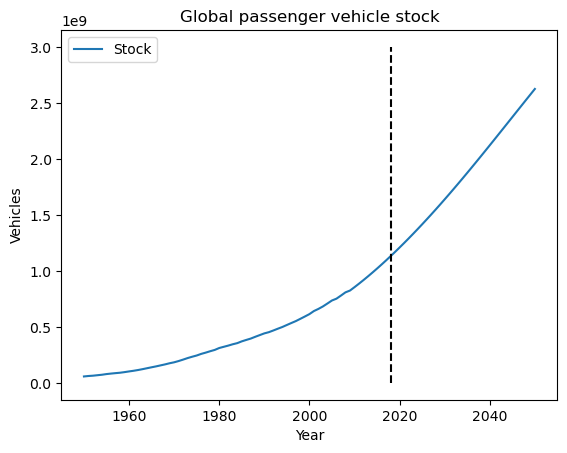

In [7]:
plt2, = plt.plot(GlobalVehicles_DSM.t, GlobalVehicles_DSM.s)
plt4, = plt.plot([2018,2018],[0,3e9], color = 'k', linestyle = '--')
plt.xlabel('Year')
plt.ylabel('Vehicles')
plt.title('Global passenger vehicle stock')
plt.legend([plt2], ['Stock'], loc = 2)
plt.show();

The curve shows constant growth with a current (20018) fleet size of ca. 1.1 billion vehicles. 

Let's also check inflow and outflow:

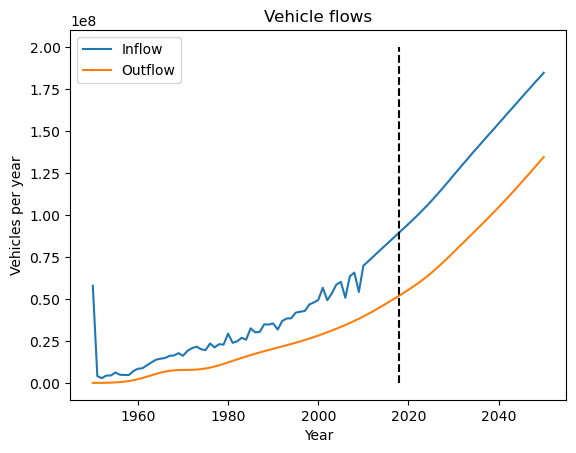

In [8]:
plt1, = plt.plot(GlobalVehicles_DSM.t, GlobalVehicles_DSM.i)
plt3, = plt.plot(GlobalVehicles_DSM.t, GlobalVehicles_DSM.o)
plt4, = plt.plot([2018,2018],[0,2e8], color = 'k', linestyle = '--')
plt.xlabel('Year')
plt.ylabel('Vehicles per year')
plt.title('Vehicle flows')
plt.legend([plt1,plt3], ['Inflow','Outflow'], loc = 2)
plt.show();

We see typical result of a stock-driven model with the following main features:

+ __Bump in first year:__ Since the model does not consider the initial stock of vehicles present in 1950, the entire global fleet has to be built up in that year, leading to the model artifact in form of a huge inflow in the first year to re-build the global fleet. Since most of these vehicles have long gone (average vehicle lifetime is ca. 16 years), this bump does not have an impact on the current fleet composition. Its ocurrence can be avoided by extending the time horizon further into the past or by feeding the initial stock into the model (cf. IEooc_Methods3_Software1).

+ __Ripples on inflow curve for historic years:__ In the stock-driven model the inflow is determined from the mass balance, hence it consists of two terms: The stock change and the outflow. Any change in the historic growth speed of the stock will directly translate into jumps of the stock change, which appear as ripples on the inflow curve.

+ __No ripples on inflow curve for future years:__ Usually, smooth curves are chosen fur future stock patterns and there is no abrupt change in stock change for these curves, hence the inflow is also a smooth curve.

+ __Outflow follows inflow with time delay of ca. average lifetime:__ The global stock keeps growing and the inflow of one year appears as outlow around the average lifetime of the products.

Let's have a look at the stock by age-cohort:

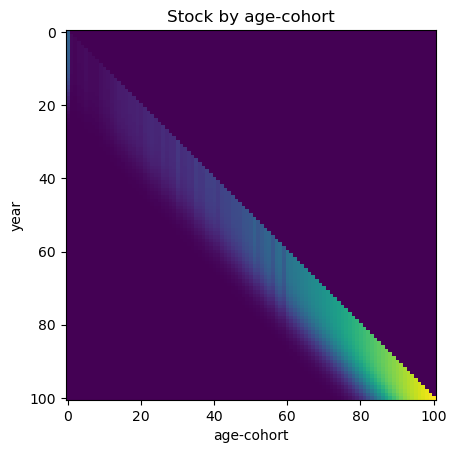

In [9]:
plt.imshow(GlobalVehicles_DSM.s_c,interpolation='nearest')
plt.xlabel('age-cohort')
plt.ylabel('year')
plt.title('Stock by age-cohort')
plt.show();

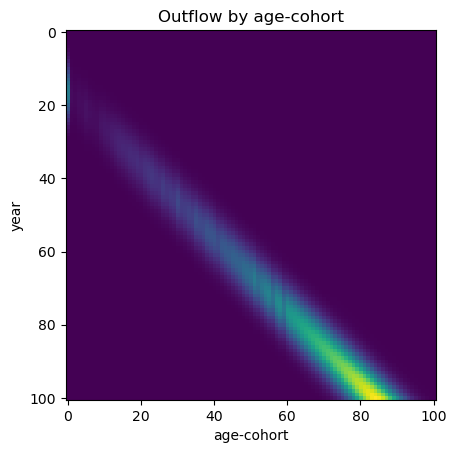

In [10]:
plt.imshow(GlobalVehicles_DSM.o_c,interpolation='nearest')
plt.xlabel('age-cohort')
plt.ylabel('year')
plt.title('Outflow by age-cohort')
plt.show();

After having convinced ourselves that the model results are reasonable, we now turn to our research question, the determination of the material inflow. This calculation is done outside the dynamic stock model:

In [11]:
Inflow_Steel = GlobalVehicles_DSM.i * np.array(CarSteelContent)
Inflow_Alu   = GlobalVehicles_DSM.i * np.array(CarAluContent)

This calculation confirms that the model works correctly. With the same lifetime distribution the historic apparent steel consumption is reproduced, and the difference between the two inflow time series (the original historic data and the re-calculated one from the stock-driven model) is practically zero.

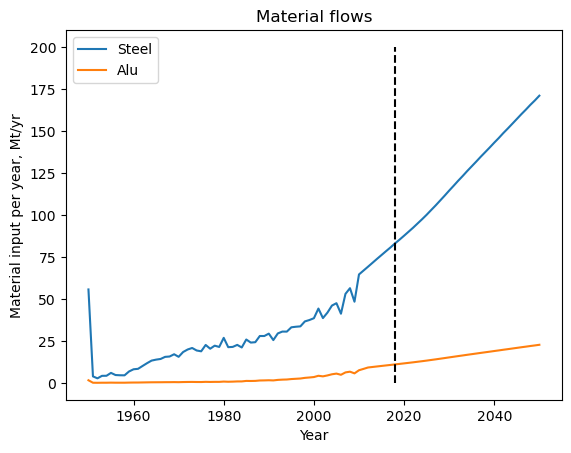

In [12]:
plt1, = plt.plot(GlobalVehicles_DSM.t, Inflow_Steel / 1e9)
plt3, = plt.plot(GlobalVehicles_DSM.t, Inflow_Alu   / 1e9)
plt4, = plt.plot([2018,2018],[0,2e2], color = 'k', linestyle = '--')
plt.xlabel('Year')
plt.ylabel('Material input per year, Mt/yr')
plt.title('Material flows')
plt.legend([plt1,plt3], ['Steel','Alu'], loc = 2)
plt.show();

Currently (2018), ca. 85 Mt/yr of steel and 11 Mt/yr of aluminium are needed to produce passenger vehicles to maintain and expand the global fleet, that corresponds to about 5% and 19% of global steel and aluminium production, respectively.

One can also compute the total material stock in the vehicle fleet and the amout of steel and alu in end-of-life vehicles, for example, by using numpy's Einstein sum function (https://stackoverflow.com/questions/26089893/understanding-numpys-einsum):

In [13]:
Steel_Stock_ByCohort   = np.einsum('tc,c->tc',GlobalVehicles_DSM.s_c,CarSteelContent) # in kg, s_c has dimension year x cohort
Alu_Stock_ByCohort     = np.einsum('tc,c->tc',GlobalVehicles_DSM.s_c,CarAluContent)   # in kg, s_c has dimension year x cohort
# index t stands for year/time, index c for age-cohort

Steel_Outflow_ByCohort = np.einsum('tc,c->tc',GlobalVehicles_DSM.o_c,CarSteelContent) # in kg, o_c has dimension year x cohort
Alu_Outflow_ByCohort   = np.einsum('tc,c->tc',GlobalVehicles_DSM.o_c,CarAluContent)   # in kg, o_c has dimension year x cohort
# index t stands for year/time, index c for age-cohort

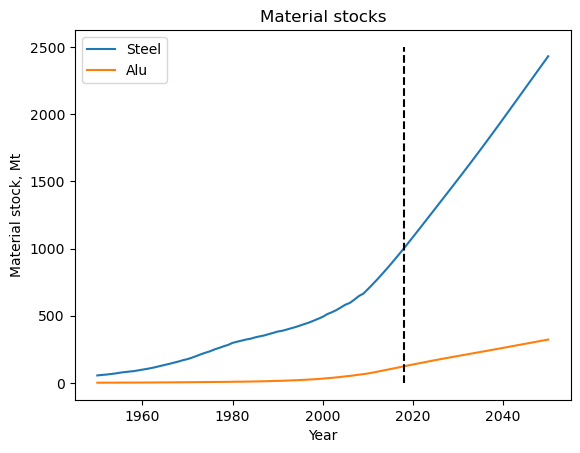

In [14]:
plt1, = plt.plot(GlobalVehicles_DSM.t, Steel_Stock_ByCohort.sum(axis =1) / 1e9)
plt3, = plt.plot(GlobalVehicles_DSM.t, Alu_Stock_ByCohort.sum(axis =1) / 1e9)
plt4, = plt.plot([2018,2018],[0,2.5e3], color = 'k', linestyle = '--')
plt.xlabel('Year')
plt.ylabel('Material stock, Mt')
plt.title('Material stocks')
plt.legend([plt1,plt3], ['Steel','Alu'], loc = 2)
plt.show();

The 2018 steel and aluminium stocks in the global passenger vehicle fleet are about 1000 Mt and 125 Mt, respectively. These stocks will become available for recycling over the next 16 years.